# Image to video with gpt-4o and Sora

Sora is an AI model from OpenAI that can create realistic and imaginative video scenes from text instructions. The model is capable of generating a wide range of video content, including realistic scenes, animations, and special effects. Several video resolutions and durations are supported.

https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/video-generation

In [1]:
import base64
import cv2
import datetime
import numpy as np
import openai
import os
import requests
import sys
import time

from dotenv import load_dotenv
from io import BytesIO
from IPython.display import Image, Video, FileLink, Audio
from mimetypes import guess_type
from openai import AzureOpenAI

In [2]:
sys.version

'3.12.10 (v3.12.10:0cc81280367, Apr  8 2025, 08:46:59) [Clang 13.0.0 (clang-1300.0.29.30)]'

In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 03-Jun-2025 14:32:20


## Settings

In [4]:
load_dotenv("azure.env")

endpoint = os.getenv('AZURE_OPENAI_ENDPOINT')
api_key = os.getenv('AZURE_OPENAI_API_KEY')

api_version = "2025-04-01-preview"
model = "gpt-4.1"
sora_model = "sora"

In [5]:
IMAGES_DIR = "images"

In [6]:
OUTPUT_DIR = "videos"

os.makedirs(OUTPUT_DIR, exist_ok=True)

## Helper

In [7]:
def local_image_to_data_url(image_path):
    """
    Converts a local image file to a data URL.

    Parameters:
    image_path (str): Path to the local image file.

    Returns:
    str: A data URL containing the base64-encoded image data.
    """
    mime_type, _ = guess_type(image_path)

    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(
            image_file.read()).decode("utf-8")

    return f"data:{mime_type};base64,{base64_encoded_data}"

In [8]:
def describe_image_with_gpt41(image_file, prompt):
    """
    Uses GPT-4.1 to analyze an image.

    Parameters:
    image_file (str): Path to the image file to be analyzed.
    prompt (str): Text prompt describing what to analyze in the image.

    Returns:
    str: The description generated by GPT-4o based on the image and prompt.

    The function initializes an AzureOpenAI client, sends a request to the GPT-4o model with the image and prompt, 
    and returns the generated description. The image is converted to a data URL before being sent to the model.
    """
    client = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        base_url=f"{endpoint}/openai/deployments/{model}",
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role":
                "system",
                "content":
                "You are an AI helpful assistant to analyse an image.",
            },
            {
                "role":
                "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": local_image_to_data_url(image_file)
                        },
                    },
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.7,
    )

    return response.choices[0].message.content

In [9]:
def sora(prompt, width=480, height=480, n_seconds=5):
    """
    Generates a video based on the given prompt using the SORA model.

    Parameters:
    prompt (str): The text prompt to generate the video.
    width (int): The width of the video. Supported values are 480, 854, 720, 1080, and 1920.
    height (int): The height of the video. Supported values are 480, 854, 720, 1080, and 1920.
    n_seconds (int): The duration of the video in seconds. Must be between 1 and 20 seconds.
    n_variants (int): The number of video variants to generate.
    
    Returns:
    str: The filename of the generated video.

    Raises:
    Exception: If the video generation job fails or no generations are found.
    """
    start = time.time()

    api_version = 'preview'
    headers = {"api-key": api_key, "Content-Type": "application/json"}

    idx = datetime.datetime.today().strftime('%d%b%Y_%H%M%S')
    output_filename = os.path.join(OUTPUT_DIR, f"image_to_video_sora_{idx}_{image_file.split('/')[-1].split('.')[0]}.mp4")

    # 1. Create a video generation job
    create_url = f"{endpoint}/openai/v1/video/generations/jobs?api-version={api_version}"
    body = {
        "prompt": prompt,
        "width": width,  # 480x480, 480x854, 854x480, 720x720, 720x1280, 1280x720, 1080x1080, 1080x1920, 1920x1080.
        "height": height,  # 480x480, 480x854, 854x480, 720x720, 720x1280, 1280x720, 1080x1080, 1080x1920, 1920x1080.
        "n_seconds": n_seconds,  # between 1 and 20 seconds
        "model": sora_model,  # SORA model
    }
    response = requests.post(create_url, headers=headers, json=body)
    response.raise_for_status()

    now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')
    print(f"{now} Full response JSON:", response.json())
    print()

    job_id = response.json()["id"]
    now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')
    print(f"{now} Job created: {job_id}")

    # 2. Poll for job status
    status_url = f"{endpoint}/openai/v1/video/generations/jobs/{job_id}?api-version={api_version}"
    status = None

    while status not in ("succeeded", "failed", "cancelled"):
        time.sleep(5)  # Wait before polling again
        status_response = requests.get(status_url, headers=headers).json()
        status = status_response.get("status")
        now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')
        print(f"{now} Job status: {status}")

    # 3. Retrieve generated video
    if status == "succeeded":
        generations = status_response.get("generations", [])
        
        if generations:
            now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')
            print(f"\n{now} ✅ Done. Video generation succeeded.")
            generation_id = generations[0].get("id")
            video_url = f"{endpoint}/openai/v1/video/generations/{generation_id}/content/video?api-version={api_version}"
            video_response = requests.get(video_url, headers=headers)

            if video_response.ok:
                # Downloading the video
                print("\nDownloading the video...")
                with open(output_filename, "wb") as file:
                    file.write(video_response.content)
                    print(f"SORA Generated video saved: '{output_filename}'")

                elapsed = time.time() - start
                minutes, seconds = divmod(elapsed, 60)
                print(
                    f"Done in {minutes:.0f} minutes and {seconds:.0f} seconds")

                return output_filename
        else:
            raise Exception("Error. No generations found in job result.")
    else:
        raise Exception(f"Error. Job did not succeed. Status: {status}")

## Example 1

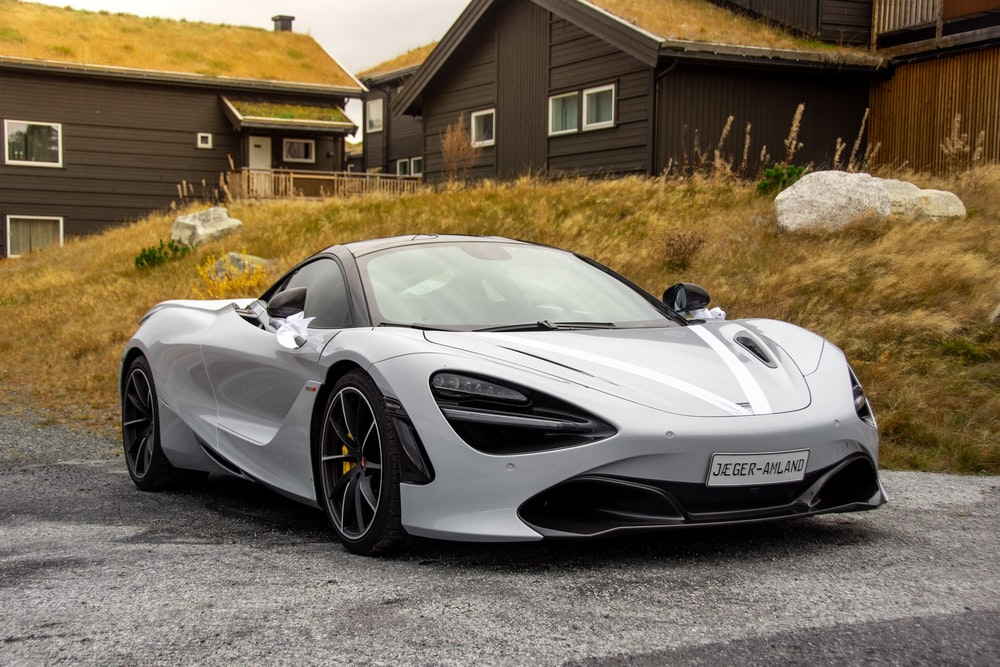

In [23]:
image_file = os.path.join(IMAGES_DIR, "car.jpg")

Image(image_file, width=640)

In [11]:
description = describe_image_with_gpt41(image_file, "Describe the following image in detail, including the main objects, their colors, positions, motions and any notable features")

print(description)

This image features a high-end sports car, a McLaren 720S, parked on a paved area. Here’s a detailed description:

**Main Objects:**
- **Car:** The most prominent object is the McLaren 720S, which takes up most of the foreground. It is angled slightly to the left, allowing a view of both the front and the driver's side.
- **Background Houses:** Behind the car, there are modern, dark brown wooden houses with grass-covered roofs, typical of Scandinavian or Nordic architecture.

**Colors:**
- **Car:** The car is primarily a glossy silver/white with a black roof and black lower accents. There is a white racing stripe running along the center of the car from the hood up to the roof. The wheels are black with silver rims, and the brake calipers are yellow.
- **Background:** The houses are dark brown or black with white window frames. The grass on the roofs and the surrounding area is a golden yellowish-brown, suggesting either autumn or a dry summer.
- **Other Elements:** There are some gree

In [12]:
sora_prompt = f"Based on the following descriptions of an image:\n {description} \nPlease create a coherent generative AI prompt that can be used to generate a video."

print(sora_prompt)

Based on the following descriptions of an image:
 This image features a high-end sports car, a McLaren 720S, parked on a paved area. Here’s a detailed description:

**Main Objects:**
- **Car:** The most prominent object is the McLaren 720S, which takes up most of the foreground. It is angled slightly to the left, allowing a view of both the front and the driver's side.
- **Background Houses:** Behind the car, there are modern, dark brown wooden houses with grass-covered roofs, typical of Scandinavian or Nordic architecture.

**Colors:**
- **Car:** The car is primarily a glossy silver/white with a black roof and black lower accents. There is a white racing stripe running along the center of the car from the hood up to the roof. The wheels are black with silver rims, and the brake calipers are yellow.
- **Background:** The houses are dark brown or black with white window frames. The grass on the roofs and the surrounding area is a golden yellowish-brown, suggesting either autumn or a dry

In [13]:
generated_video_file = sora(sora_prompt, width=1280, height=720, n_seconds=7)

03-Jun-2025 14:32:28 Full response JSON: {'object': 'video.generation.job', 'id': 'task_01jwvh1y15ftvr3hassw262zjd', 'status': 'queued', 'created_at': 1748975548, 'finished_at': None, 'expires_at': None, 'generations': [], 'prompt': 'Based on the following descriptions of an image:\n This image features a high-end sports car, a McLaren 720S, parked on a paved area. Here’s a detailed description:\n\n**Main Objects:**\n- **Car:** The most prominent object is the McLaren 720S, which takes up most of the foreground. It is angled slightly to the left, allowing a view of both the front and the driver\'s side.\n- **Background Houses:** Behind the car, there are modern, dark brown wooden houses with grass-covered roofs, typical of Scandinavian or Nordic architecture.\n\n**Colors:**\n- **Car:** The car is primarily a glossy silver/white with a black roof and black lower accents. There is a white racing stripe running along the center of the car from the hood up to the roof. The wheels are black

In [14]:
Video(generated_video_file, width=1024)

In [15]:
video_link = FileLink(path=generated_video_file)
video_link

/Users/arturoquiroga/GITHUB/SORA/sora-2/videos/image_to_video_sora_03Jun2025_143228_car.mp4

In [24]:
# Mixing the initial image on the left and the SORA video on the right
output_path = os.path.join(OUTPUT_DIR, "image_sora_car.mp4")

left_image = cv2.imread(image_file)
video = cv2.VideoCapture(generated_video_file)

fps = video.get(cv2.CAP_PROP_FPS)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
left_image_resized = cv2.resize(
    left_image,
    (int(height * left_image.shape[1] / left_image.shape[0]), height))
combined_width = left_image_resized.shape[1] + width
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (combined_width, height))

while True:
    ret, frame = video.read()
    if not ret:
        break
    combined_frame = np.hstack((left_image_resized, frame))
    out.write(combined_frame)

video.release()
out.release()

video_link = FileLink(path=output_path)
video_link

/Users/arturoquiroga/GITHUB/SORA/sora-2/videos/image_sora_car.mp4

## Example 2

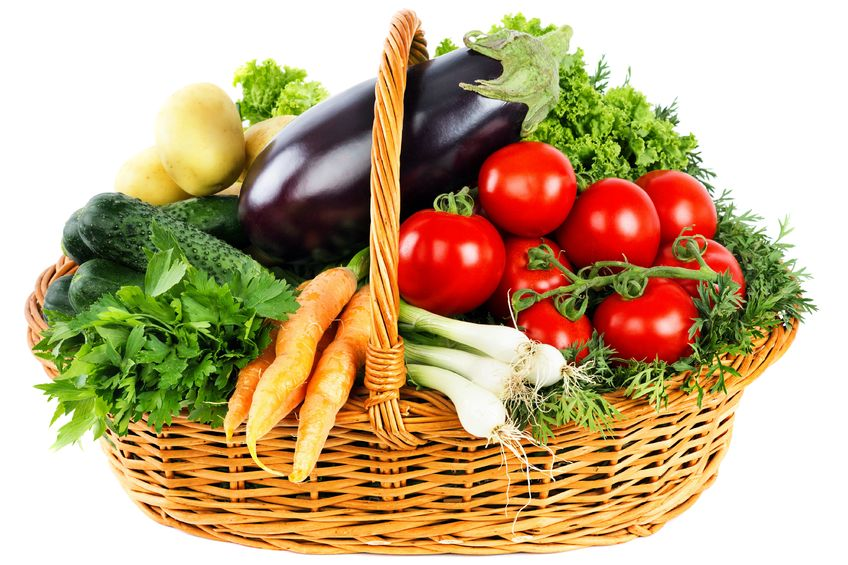

In [25]:
image_file = os.path.join(IMAGES_DIR, "food.jpg")

Image(image_file, width=640)

In [27]:
description = describe_image_with_gpt41(image_file, "Describe the following image in detail, including the main objects, their colors, positions, motions and any notable features")

print(description)

This image shows a wicker basket filled with a colorful assortment of fresh vegetables. Here is a detailed description:

**Main Objects:**
1. **Basket:**  
   - Material: Woven wicker with a handle.
   - Color: Light brown.
   - Position: Central, holding all the vegetables.

2. **Vegetables inside the basket:**

   - **Eggplant (Aubergine):**
     - Color: Deep, glossy purple with a green stem.
     - Position: Prominently placed in the upper center, resting diagonally across the basket.
     - Notable Feature: It is the largest and most visually striking item.

   - **Tomatoes:**
     - Color: Bright red.
     - Position: Clustered in the right center of the basket, some still attached to green vines.
     - Notable Feature: There are about seven tomatoes grouped together, adding a vibrant splash of color.

   - **Carrots:**
     - Color: Orange with green leafy tops.
     - Position: In the front center, with the pointed ends facing downward and the tops draped over the edge of the 

In [28]:
sora_prompt = f"Based on the following descriptions of an image:\n {description} \nPlease create a coherent generative AI prompt that can be used to generate a video."

In [29]:
generated_video_file = sora(sora_prompt, width=1280, height=720, n_seconds=5)

03-Jun-2025 14:38:05 Full response JSON: {'object': 'video.generation.job', 'id': 'task_01jwvhc7ktea59dj2tqk8t7tjz', 'status': 'queued', 'created_at': 1748975885, 'finished_at': None, 'expires_at': None, 'generations': [], 'prompt': 'Based on the following descriptions of an image:\n This image shows a wicker basket filled with a colorful assortment of fresh vegetables. Here is a detailed description:\n\n**Main Objects:**\n1. **Basket:**  \n   - Material: Woven wicker with a handle.\n   - Color: Light brown.\n   - Position: Central, holding all the vegetables.\n\n2. **Vegetables inside the basket:**\n\n   - **Eggplant (Aubergine):**\n     - Color: Deep, glossy purple with a green stem.\n     - Position: Prominently placed in the upper center, resting diagonally across the basket.\n     - Notable Feature: It is the largest and most visually striking item.\n\n   - **Tomatoes:**\n     - Color: Bright red.\n     - Position: Clustered in the right center of the basket, some still attached t

In [30]:
Video(generated_video_file, width=1024)

In [31]:
video_link = FileLink(path=generated_video_file)
video_link

/Users/arturoquiroga/GITHUB/SORA/sora-2/videos/image_to_video_sora_03Jun2025_143805_food.mp4

In [32]:
# Mixing the initial image on the left and the SORA video on the right
output_path = os.path.join(OUTPUT_DIR, "image_sora_food.mp4")

left_image = cv2.imread(image_file)
video = cv2.VideoCapture(generated_video_file)

fps = video.get(cv2.CAP_PROP_FPS)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
left_image_resized = cv2.resize(
    left_image,
    (int(height * left_image.shape[1] / left_image.shape[0]), height))
combined_width = left_image_resized.shape[1] + width
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (combined_width, height))

while True:
    ret, frame = video.read()
    if not ret:
        break
    combined_frame = np.hstack((left_image_resized, frame))
    out.write(combined_frame)

video.release()
out.release()

video_link = FileLink(path=output_path)
video_link

/Users/arturoquiroga/GITHUB/SORA/sora-2/videos/image_sora_food.mp4

## Example 3

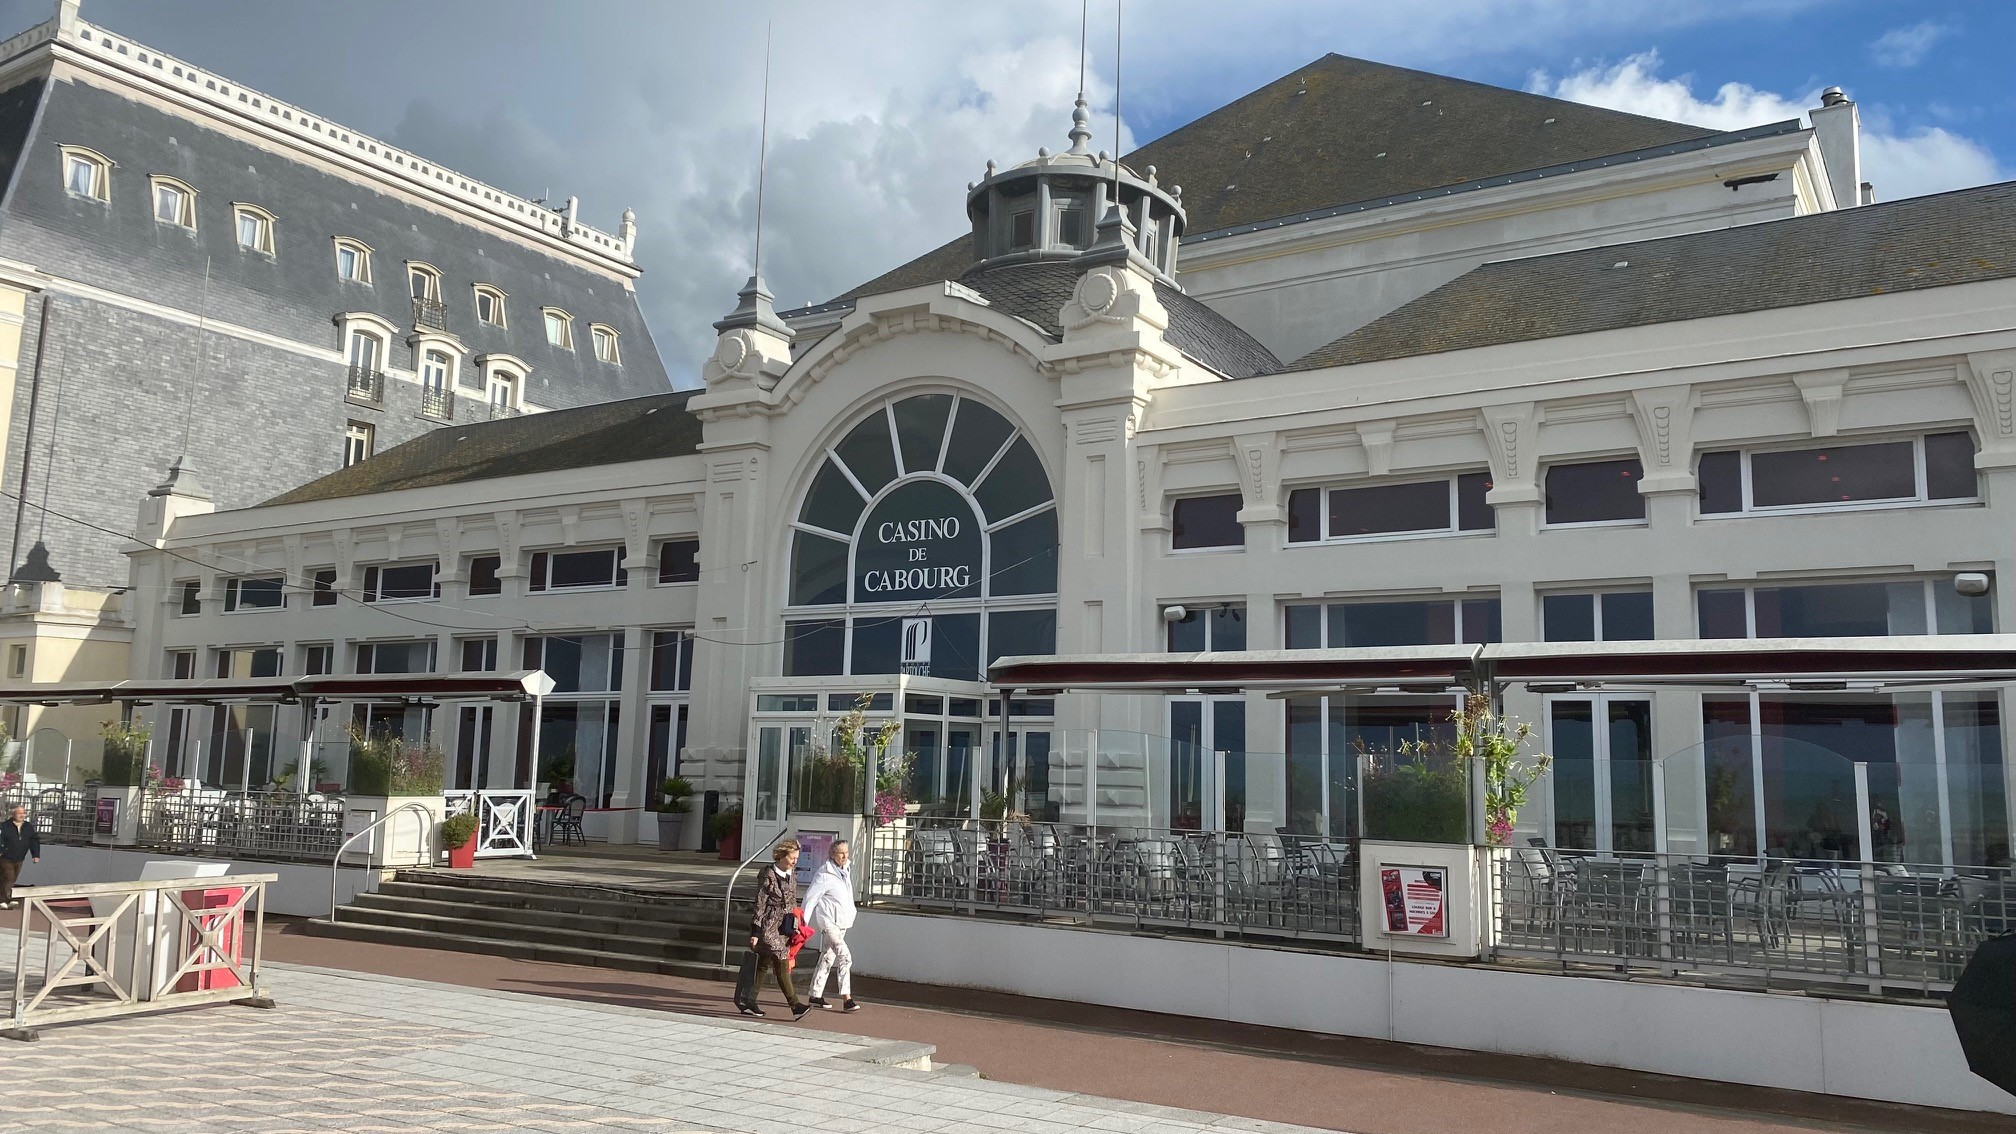

In [34]:
image_file = os.path.join(IMAGES_DIR, "cabourg.jpg")

Image(image_file, width=860)

In [35]:
description = describe_image_with_gpt41(image_file, "Describe the following image in detail, including the main objects, their colors, positions, motions and any notable features")

print(description)

The image depicts the **Casino de Cabourg**, a grand and elegant building in Cabourg, France. Here is a detailed description:

### Main Objects & Architecture:
- **Building**: The focus is on the Casino de Cabourg, a large, white, historic structure with ornate architectural details. The central portion features a prominent arched window with decorative framing and a round turret-like structure at the top, crowned with a grey, shingled roof and spires.
- **Signage**: The arched window at the center has the text “CASINO DE CABOURG” written in white on a navy blue/black background.
- **Windows**: The facade is lined with rectangular windows, both above and below, framed in white, contributing to a symmetrical and classic appearance.
- **Outdoor Area**: There is a terrace or patio area in front of the building, enclosed by glass panels and white railings, containing many stacked chairs and tables suggesting an outdoor seating area, likely for a café or restaurant.
- **Planters**: Several 

In [37]:
sora_prompt = f"Based on the following descriptions of an image:\n {description} \nPlease create a coherent generative AI prompt that can be used to generate a video."

print(sora_prompt)

Based on the following descriptions of an image:
 The image depicts the **Casino de Cabourg**, a grand and elegant building in Cabourg, France. Here is a detailed description:

### Main Objects & Architecture:
- **Building**: The focus is on the Casino de Cabourg, a large, white, historic structure with ornate architectural details. The central portion features a prominent arched window with decorative framing and a round turret-like structure at the top, crowned with a grey, shingled roof and spires.
- **Signage**: The arched window at the center has the text “CASINO DE CABOURG” written in white on a navy blue/black background.
- **Windows**: The facade is lined with rectangular windows, both above and below, framed in white, contributing to a symmetrical and classic appearance.
- **Outdoor Area**: There is a terrace or patio area in front of the building, enclosed by glass panels and white railings, containing many stacked chairs and tables suggesting an outdoor seating area, likely 

In [38]:
generated_video_file = sora(sora_prompt, width=1280, height=720, n_seconds=7)

03-Jun-2025 14:46:28 Full response JSON: {'object': 'video.generation.job', 'id': 'task_01jwvhvjhffyy82a7r3mjc0qdt', 'status': 'queued', 'created_at': 1748976388, 'finished_at': None, 'expires_at': None, 'generations': [], 'prompt': 'Based on the following descriptions of an image:\n The image depicts the **Casino de Cabourg**, a grand and elegant building in Cabourg, France. Here is a detailed description:\n\n### Main Objects & Architecture:\n- **Building**: The focus is on the Casino de Cabourg, a large, white, historic structure with ornate architectural details. The central portion features a prominent arched window with decorative framing and a round turret-like structure at the top, crowned with a grey, shingled roof and spires.\n- **Signage**: The arched window at the center has the text “CASINO DE CABOURG” written in white on a navy blue/black background.\n- **Windows**: The facade is lined with rectangular windows, both above and below, framed in white, contributing to a symme

In [39]:
Video(generated_video_file, width=1024)

In [40]:
video_link = FileLink(path=generated_video_file)
video_link

/Users/arturoquiroga/GITHUB/SORA/sora-2/videos/image_to_video_sora_03Jun2025_144628_cabourg.mp4

In [41]:
# Mixing the initial image on the left and the SORA video on the right
output_path = os.path.join(OUTPUT_DIR, "image_sora_store.mp4")

left_image = cv2.imread(image_file)
video = cv2.VideoCapture(generated_video_file)

fps = video.get(cv2.CAP_PROP_FPS)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
left_image_resized = cv2.resize(
    left_image,
    (int(height * left_image.shape[1] / left_image.shape[0]), height))
combined_width = left_image_resized.shape[1] + width
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (combined_width, height))

while True:
    ret, frame = video.read()
    if not ret:
        break
    combined_frame = np.hstack((left_image_resized, frame))
    out.write(combined_frame)

video.release()
out.release()

video_link = FileLink(path=output_path)
video_link

/Users/arturoquiroga/GITHUB/SORA/sora-2/videos/image_sora_store.mp4

## Generated videos

In [43]:
!ls -lh videos/image_sora*.mp4 

-rw-rw-r--@ 1 arturoquiroga  staff    11M Jun  3 14:36 videos/image_sora_car.mp4
-rw-rw-r--@ 1 arturoquiroga  staff   7.4M Jun  3 14:40 videos/image_sora_food.mp4
-rw-rw-r--@ 1 arturoquiroga  staff    13M Jun  3 14:47 videos/image_sora_store.mp4
